In [93]:
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.optimizers import Adam
from keras.models import load_model
from keras import layers
import os
import tensorflow as tf
import datetime
from collections import deque


df_all = pd.read_csv('NVDA.csv')
df_all.drop(columns=['Open', 'High', 'Low', 'Adj Close', 'Volume'], inplace=True)
df_all['Date'] = pd.to_datetime(df_all['Date'])
df_all = df_all[['Date', 'Close']]


df = pd.read_csv('NVDA_train.csv')
df.drop(columns=['Open', 'High', 'Low', 'Adj Close', 'Volume'], inplace=True)
df['Date'] = pd.to_datetime(df['Date'])
df = df[['Date', 'Close']]
df.index = df.pop('Date')

test_df = pd.read_csv('NVDA_test.csv')
test_df.drop(columns=['Open', 'High', 'Low', 'Adj Close', 'Volume'], inplace=True)
test_df['Date'] = pd.to_datetime(test_df['Date'])
test_df = test_df[['Date', 'Close']]
test_df.index = test_df.pop('Date')



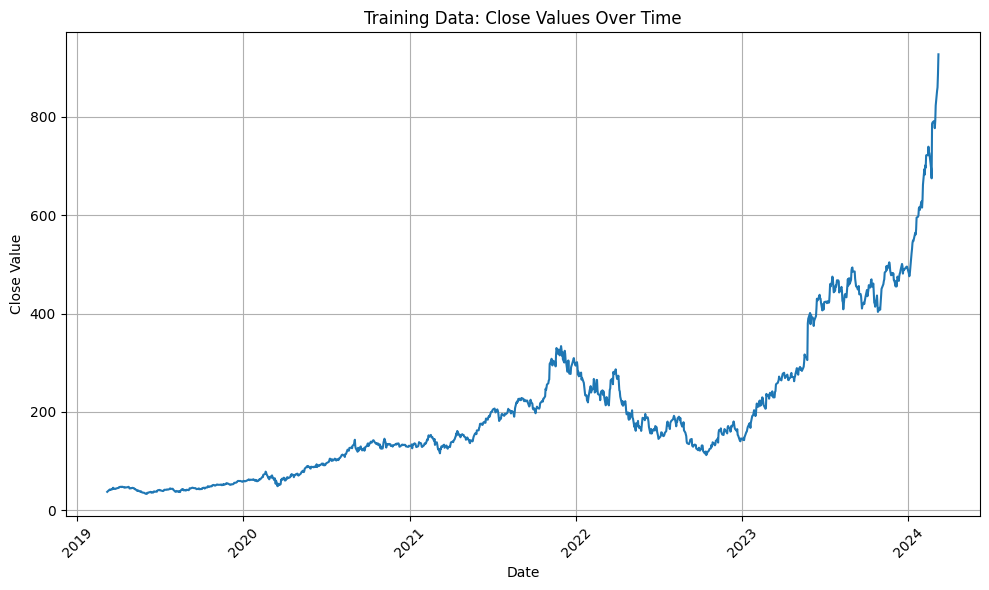

In [94]:
plt.figure(figsize=(10, 6))
plt.plot(df_all['Date'], df_all['Close'], marker='', linestyle='-')
plt.title('Training Data: Close Values Over Time')
plt.xlabel('Date')
plt.ylabel('Close Value')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


# datapreprocessing for lstm

In [33]:
def generate_windowed_dataset(dataframe, start_date_str, end_date_str, window_size=3):
    start_date = pd.to_datetime(start_date_str)
    end_date = pd.to_datetime(end_date_str)

    target_date = start_date
    dates = []
    X, y = [], []

    while True:
        window_data = dataframe.loc[:target_date].tail(window_size + 1)

        if len(window_data) != window_size + 1:
            print(f'Error: Window of size {window_size} is too large for date {target_date}')
            return

        values = window_data['Close'].to_numpy()
        X.append(values[:-1])
        y.append(values[-1])
        dates.append(target_date)

        next_date = target_date + pd.DateOffset(days=1)

        if next_date > end_date:
            break

        target_date = next_date

    ret_df = pd.DataFrame({'Target Date': dates})
    for i in range(window_size):
        ret_df[f'Target-{window_size-i}'] = np.array(X)[:, i]
    ret_df['Target'] = y

    return ret_df

# Start day second time around: '2021-03-25'
windowed_df = generate_windowed_dataset(df,
                                '2021-03-25',
                                '2022-03-23',
                                3)
windowed_df

,Target Date,Target-3,Target-2,Target-1,Target
0,2021-03-25,131.862503,130.707504,126.430000,125.352501
1,2021-03-26,130.707504,126.430000,125.352501,128.392502
2,2021-03-27,130.707504,126.430000,125.352501,128.392502
3,2021-03-28,130.707504,126.430000,125.352501,128.392502
4,2021-03-29,126.430000,125.352501,128.392502,129.482498
...,...,...,...,...,...
359,2022-03-19,229.729996,244.960007,247.660004,264.529999
360,2022-03-20,229.729996,244.960007,247.660004,264.529999
361,2022-03-21,244.960007,247.660004,264.529999,267.339996
362,2022-03-22,247.660004,264.529999,267.339996,265.239990


In [32]:
def prepare_dataset_for_lstm(windowed_dataframe):
    dates = windowed_dataframe['Target Date'].to_numpy()
    X = windowed_dataframe.iloc[:, 1:-1].to_numpy().reshape(len(windowed_dataframe), -1, 1)
    y = windowed_dataframe['Target'].to_numpy()
    return dates, X.astype(np.float32), y.astype(np.float32)

w = prepare_dataset_for_lstm(windowed_df)[1]
w.shape

(364, 3, 1)

# LSTM Baseline

## preprocessing

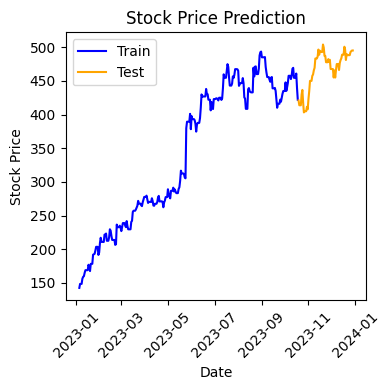

In [120]:
windowed_df = generate_windowed_dataset(df, '2023-01-05', '2023-12-29', window_size=3)
dates, X, y = prepare_dataset_for_lstm(windowed_df)

split = int(len(X) * 0.8)
X_train, y_train = X[:split], y[:split]
X_val, y_val = X[split:], y[split:]
dates_train, dates_val = dates[:split], dates[split:]

# plot
plt.figure(figsize=(4, 4))
plt.plot(dates_train, y_train, label='Train', color='blue')
plt.plot(dates_val, y_val, label='Test', color='orange')

plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Stock Price Prediction')

plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

## training

In [121]:
model = Sequential([layers.Input((3, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model.compile(loss='mse',
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=1000)


save_dir = 'trained_models'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

model.save(os.path.join(save_dir, 'baseline.keras'))

Epoch 1/1000
9/9 [==============================] - 1s 35ms/step - loss: 127187.3750 - mean_absolute_error: 341.2519 - val_loss: 218046.6250 - val_mean_absolute_error: 466.0481
Epoch 2/1000
9/9 [==============================] - 0s 4ms/step - loss: 126824.4766 - mean_absolute_error: 340.7153 - val_loss: 217548.8125 - val_mean_absolute_error: 465.5136
Epoch 3/1000
9/9 [==============================] - 0s 4ms/step - loss: 126434.4219 - mean_absolute_error: 340.1324 - val_loss: 216970.9062 - val_mean_absolute_error: 464.8925
Epoch 4/1000
9/9 [==============================] - 0s 4ms/step - loss: 125943.6094 - mean_absolute_error: 339.4052 - val_loss: 216198.6875 - val_mean_absolute_error: 464.0610
Epoch 5/1000
9/9 [==============================] - 0s 4ms/step - loss: 125184.3750 - mean_absolute_error: 338.2570 - val_loss: 214674.4219 - val_mean_absolute_error: 462.4152
Epoch 6/1000
9/9 [==============================] - 0s 4ms/step - loss: 123838.1172 - mean_absolute_error: 336.2793 - v

## plotting

9/9 [==============================] - 0s 876us/step


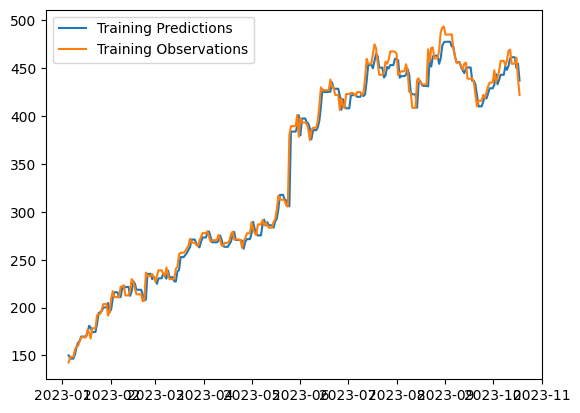

In [122]:
train_predictions = model.predict(X_train).flatten()

plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Observations'])

3/3 [==============================] - 0s 2ms/step


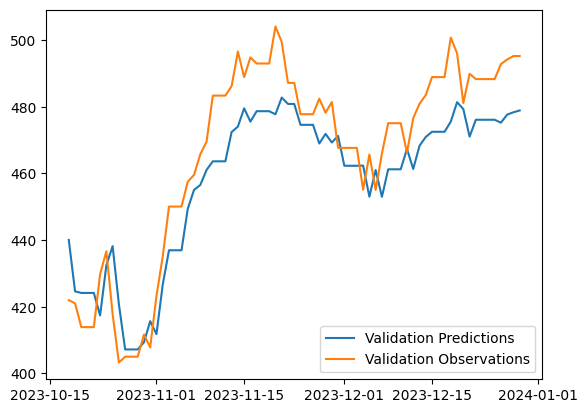

In [9]:
val_predictions = model.predict(X_val).flatten()

plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.legend(['Validation Predictions', 'Validation Observations'])

## evaluating on test set

1/1 [==============================] - 0s 404ms/step - loss: 1935.5035 - mean_absolute_error: 41.9025
Test Loss: 1935.5035400390625
Test Mean Absolute Error: 41.90248107910156
[Timestamp('2024-01-09 00:00:00'), Timestamp('2024-01-10 00:00:00'), Timestamp('2024-01-11 00:00:00'), Timestamp('2024-01-12 00:00:00'), Timestamp('2024-01-16 00:00:00')]
deque([531.400024, 543.5, 548.219971], maxlen=3)
[531.400024, 543.5, 548.219971]
1/1 [==============================] - 0s 14ms/step


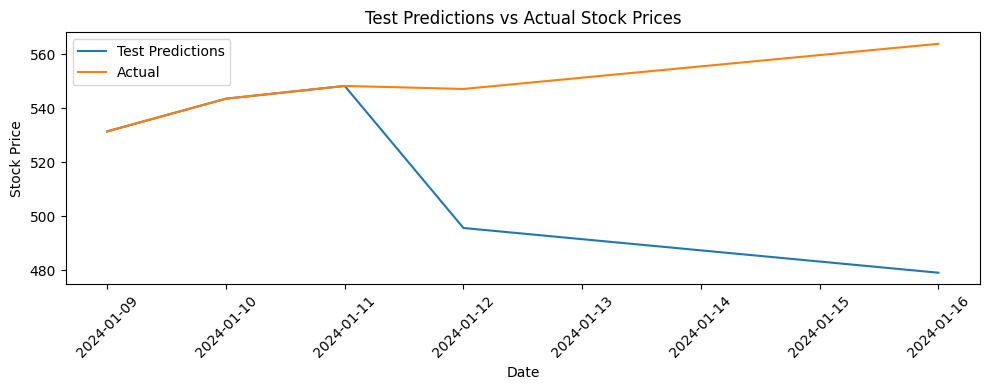

In [110]:
model = load_model('trained_models/baseline.keras')

windowed_test_df = generate_windowed_dataset(test_df, '2024-01-05', '2024-01-15', window_size=3)
dates_test, X_test, y_test = prepare_dataset_for_lstm(windowed_test_df)

# print(dates_test)

loss, mae = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')
print(f'Test Mean Absolute Error: {mae}')

n = 5
s = 1


values = test_df[['Close']].iloc[s:s+3].to_numpy().flatten().tolist()
dates = test_df.iloc[s:s+n].index.to_list()

print(dates)


measures = deque(values, maxlen=3)
measures_list = list(measures)

print(measures)
print(measures_list)

for date in range(n-3):
    x = np.array(measures, dtype=float).reshape((1,3,1))
    pred_measure = model.predict(x).flatten()[0]
    measures.append(pred_measure)
    values.append(pred_measure)


plt.figure(figsize=(10, 4))
# plt.plot(df)
plt.plot(dates, values, label='Test Predictions')
plt.plot(dates, test_df[['Close']].iloc[s:s+n].to_numpy().flatten().tolist(), label='Actual')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Test Predictions vs Actual Stock Prices')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# Very bad extrapolation (learn data outside its range), for it to better extrapolate we can train it on a smaller interval closer the dates we actually want to predict